In [104]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [105]:
# FUNCTION: 
# Example call:   tf_variable = get_nn_parameter(...)
def get_nn_parameter(variable_scope, variable_name, dim1, dim2):
    '''
    Used to retrieve or create new NN parameters (weights & biases)
    When calling, the corresponding NNparameter's dimensions need to be specified too.
    Returns a tensorflow variable. Note that NN parameters need to be tensorflow variables
    so that values can be changed whenever needed when training. Also note that it is 
    explicitly defined that the created variable is TRAINABLE.
    '''
    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
      v = tf.get_variable(variable_name, 
                          [dim1, dim2], 
                          trainable=True, 
                          initializer = tf.contrib.layers.xavier_initializer())
    return v

In [106]:
# FUNCTION: 
# Example call:   nn_parameters = initialize_layer_parameters([3, 5, 5, 2])
def initialize_layer_parameters(num_units_in_layers):
    '''
    NOTE THAT THE LAST LAYER HAS TO HAVE AT LEAST 2 UNITS BCZ SOFTMAX IS USED IN THIS NN MODEL
    Returns a dictionary of created weights and biases for all layers of the NN.
    Note that # units can vary in each layer.
    Exmaple return: parameters = {"W1": tf_variable_for_W1, "b1": tf_variable_for_b1, ...}
    '''
    
    parameters = {}
    L = len(num_units_in_layers)
     
    for i in range (1, L):
        #print("W" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(num_units_in_layers[i-1]))
        temp_weight = get_nn_parameter("weights",
                                       "W"+str(i), 
                                       num_units_in_layers[i], 
                                       num_units_in_layers[i-1])
        parameters.update({"W" + str(i) : temp_weight})  
        
        #print("b" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(1))
        temp_bias = get_nn_parameter("biases",
                                     "b"+str(i), 
                                     num_units_in_layers[i], 
                                     1)
        parameters.update({"b" + str(i) : temp_bias})  
        
    return parameters

In [144]:
def forward_propagation_with_relu(X, num_units_in_layers, parameters, 
                                  normalize_batch, training, moving_avg_momentum, 
                                  dropout_rates_per_layer, normalize_input, mu, sigma_square):

    # X has the shape (num_features, num_examples), where num_examples = minibatch_size
    
    L = len(num_units_in_layers)

    if normalize_input:
        X = tf.divide(tf.subtract(X, mu), sigma_square)
    
    A_temp = tf.transpose(X)
    
    for i in range (1, L):
        W = parameters.get("W"+str(i))
        b = parameters.get("b"+str(i))
        Z_temp = tf.add(tf.matmul(W, A_temp), b)
        if normalize_batch:
            if (i < (L-1)):    # Do NOT batch normalize the output layer 
                with tf.variable_scope("batch_norm_scope", reuse=tf.AUTO_REUSE):
                    Z_temp = tf.layers.batch_normalization(Z_temp, axis=0, 
                                                           training=training,
                                                           momentum=moving_avg_momentum)

        A_temp = tf.nn.relu(Z_temp)
        if (i < (L-1)):     # Do NOT apply dropout in output layer
            A_temp = tf.layers.dropout(A_temp, rate=dropout_rates_per_layer[i], training=training)
            
    batch_predictions = tf.argmax(A_temp, 0)
    
    return batch_predictions, Z_temp   #This is the linear output of last layer

In [237]:
# FUNCTION
# This function requires update if softmax is not used in the output layer
def compute_cost(ZL, Y, parameters, lambd, num_classes, mb_size):
    """
    This function should be used for multinomial mutually exclusive classification, i.e. pick one out of N classes. 
    Also applicable when N = 2.
    The labels must be one-hot encoded or can contain soft class probabilities: a particular example can belong to
    class A with 50% probability and class B with 50% probability. Note that strictly speaking it doesn't mean that
    it belongs to both classes, but one can interpret the probabilities this way.
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as ZL
    mb_size -- number of samples in the given mini-batch
    lambd -- lambda regularization parameter (regularization deactivated is lambd=0.)
    
    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)      # ZL.shape = (num_features x minibatch_size)
    labels = tf.squeeze(tf.one_hot(Y, num_classes), 1)
    
    # This cost calculation is unregularized. cost = (1/m) sum(Loss(y_hat(i), y(i))), where i = 1,..,mb_size 
    #tf.reduce_mean(..) function finds the mean of costs of examples in the given mini-batch
    cost_unregularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    # Add L2 regularization: cost += (lambd / (2 * mb_size)) * sum(W(i,j)**2), where i:1,..,n[l] and j:1,..,n[l-1] 
    # L:number of layers. Since the dict parameters includes both W and b, it needs to be divided with 2 to find L
    L = len(parameters) // 2
    
    # The list will have L elements, each holding the sum of weight matrix values in each layer. Later, these
    # weight values need to be summed up again
    list_sum_weights = []
    
    for i in range (0, L):
        list_sum_weights.append(tf.nn.l2_loss(parameters.get("W"+str(i+1))))
    
    # in the following calculation, since the l2_loss returns "sum(t ** 2) / 2", where the sum of squares is already
    # divided by 2, there is no need to bultiply the mb_size with 2
    #regularization_effect = (lambd / mb_size) * sum(list_sum_weights)
    regularization_effect = tf.multiply((lambd / mb_size), tf.add_n(list_sum_weights))
    cost = tf.add(cost_unregularized, regularization_effect)
    
    return cost

In [238]:
# UPDATE-1 IN EACH PROJECT (depending on default values for each column)
# Determine default values for each column in case data is missing
record_defaults = [[""], [0.0], [0.0], [0.0], [0.0], [0.0], [0]]

def decode_csv(line):
    parsed_line = tf.decode_csv(line, record_defaults)
    #label = parsed_line[-2:]          # last 2 columns are labels
    label = parsed_line[-1:]          # last column is labels
    del parsed_line[-1]               # delete the last element from the list   (label column)
    #del parsed_line[-2]               # delete the second last element from the list. (label column)
    del parsed_line[0]                # even delete the first element bcz it is assumed NOT to be a feature
    features = tf.stack(parsed_line)  # Stack features so that you can later vectorize forward prop., etc.
    label = tf.stack(label)           # Needed bcz labels consist of 2 columns
    batch_to_return = features, label

    return batch_to_return


In [245]:
def nn_model(num_classes, train_input_paths, dev_input_paths, test_input_paths, normalize_input,
             mu, sigma_square, initial_learning_rate, decay_steps, decay_rate, num_train_epochs, 
             normalize_batch, moving_avg_momentum, epoch_period_to_save_cost, minibatch_size, 
             num_units_in_layers, lambd, dropout_rates_per_layer, print_progress):
    """
    Returns NN parameters after the completion of training.
    """

    tf.reset_default_graph()     # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)       # tf.reset_default_graph() needs to be run first before 
                                # calling tf.set_random_seed(..)
    
    costs_train = []                            
    accuracies_train = []
    costs_dev = []
    accuracies_dev = []

    num_epochs= num_train_epochs
    input_paths = train_input_paths

    training = tf.placeholder(tf.bool)    
    
    with tf.name_scope("init_nn_params"):
        # Initialize parameters
        parameters = initialize_layer_parameters(num_units_in_layers)    

    with tf.name_scope("next_train_batch"):
        filenames = tf.placeholder(tf.string, shape=[None])
        dataset = tf.data.Dataset.from_tensor_slices(filenames)
        dataset = dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename).skip(1).map(decode_csv))
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(minibatch_size)
        iterator = dataset.make_initializable_iterator()
        X_mini_batch, Y_mini_batch = iterator.get_next()

    with tf.name_scope("forward_prop"):
        # Forward propagation: Build the forward propagation in the tensorflow graph
        batch_predictions, ZL = forward_propagation_with_relu(X_mini_batch, num_units_in_layers, 
                                                              parameters, normalize_batch, training, 
                                                              moving_avg_momentum, dropout_rates_per_layer,
                                                              normalize_input, mu, sigma_square)

    with tf.name_scope("calc_cost"):
        # Cost function: Add cost function to tensorflow graph
        cost_mini_batch = compute_cost(ZL, Y_mini_batch, parameters, lambd, num_classes,
                                       mb_size=tf.cast(X_mini_batch.shape[1], dtype=tf.float32))

    with tf.name_scope("learning_decay_scope"):
        # Global_step to use for the decay computation. Must not be negative.
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                                   global_step, 
                                                   decay_steps,  
                                                   decay_rate,  # how much will alphe be decayed?
                                                   staircase=False)        
        
    with tf.name_scope("train"):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):        
            # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
            optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_mini_batch,
                                                                                        global_step=global_step)        
    
    with tf.name_scope("metric_accuracy"):
        # Define the metric and update operations
        accuracy, accuracy_update = tf.metrics.accuracy(Y_mini_batch,
                                                        batch_predictions)
        
    with tf.name_scope("reset_metric_variables"):
        # Isolate the variables stored behind the scenes by the metric operation
        accuracy_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="metric_accuracy")
        #precision_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="metric_precision")
        #recall_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="metric_recall")
        metrics_var_list = accuracy_vars #+ precision_vars + recall_vars
        # Define initializer to initialize/reset running variables
        tf_metrics_vars_initializer = tf.variables_initializer(var_list=metrics_var_list) 
        
    # Initialize all the variables
    init_global_var = tf.global_variables_initializer() 
    init_local_var = tf.local_variables_initializer()   

    # Define a saver to save session params periodically
    #saver = tf.train.Saver(max_to_keep=500)
    saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=500)
    
    # sess is created fo the training phase
    with tf.Session() as sess:
        #print(sess.graph)
        sess.run(init_global_var)
        # initializing local variables needed to be able to set num_epochs
        sess.run(init_local_var)

        epoch_nr = 0
        for _ in range(num_train_epochs // epoch_period_to_save_cost): 
            # Train epoch_period_to_save_cost epochs. Then validate train set. Then validate dev set.
            for _ in range(epoch_period_to_save_cost):
                sum_minibatch_costs = 0
                nr_of_minibatches = 0
                sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
                sess.run(iterator.initializer, feed_dict={filenames: train_input_paths})
                while True:
                    try:
                      _ , minibatch_cost, _ = sess.run([optimizer, 
                                                       cost_mini_batch, 
                                                       accuracy_update],
                                                       feed_dict={training: True})
                      nr_of_minibatches += 1
                      sum_minibatch_costs += minibatch_cost
                    except tf.errors.OutOfRangeError:
                      epoch_nr += 1
                      #print("Out of range error triggered (looped through training set 1 time)")
                      break
                    
            # Note that cost and accuracy reporting is done on the entire train set, not based on a subset
            current_cost_train = sum_minibatch_costs / nr_of_minibatches
            costs_train.append(current_cost_train)
            accuracies_train.append(sess.run(accuracy))
            if print_progress:
                print ("TRAIN: After epoch %i: Cost: %f   Accuracy: %f" % 
                       (epoch_nr, current_cost_train, accuracies_train[-1]))
            
            
            # BEfore continuing training...
            # Now run validation on dev set to keep track of development (to later check bias/variance)

            sum_minibatch_costs = 0
            nr_of_minibatches = 0
            sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
            sess.run(iterator.initializer, feed_dict={filenames: dev_input_paths})
            while True:
                try:
                  minibatch_cost, _ = sess.run([cost_mini_batch, 
                                               accuracy_update],
                                               feed_dict={training: False})
                  nr_of_minibatches += 1
                  sum_minibatch_costs += minibatch_cost
                except tf.errors.OutOfRangeError:
                  #print("Out of range error triggered (looped through dev set 1 time only)")
                  break        
            # Note that cost and accuracy reporting is done on the entire dev set, not based on a subset
            current_cost_dev = sum_minibatch_costs / nr_of_minibatches
            costs_dev.append(current_cost_dev)
            accuracies_dev.append(sess.run(accuracy))
            if print_progress:
                print ("DEV:   After epoch %i: Cost: %f   Accuracy: %f\n" % 
                       (epoch_nr, current_cost_dev, accuracies_dev[-1]))
    
            # Save the model periodically (after each epoch_period_to_save_cost epochs)
            dir = os.path.join("./checkpoint_dir", "my_nn_model")
            finfo = saver.save(sess, dir, global_step=epoch_nr)  
            #print(str(epoch_nr) + "  " + finfo + "\n")

        parameters = sess.run(parameters)
        
        # Training is completed at this point.
        #Calculate test set cost & accuracy. Improving test set cost is not the target here.Just further information..
        sum_minibatch_costs = 0
        nr_of_minibatches = 0
        sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
        sess.run(iterator.initializer, feed_dict={filenames: test_input_paths})
        while True:
            try:
              minibatch_cost, _ = sess.run([cost_mini_batch, 
                                           accuracy_update],
                                           feed_dict={training: False})
              nr_of_minibatches += 1
              sum_minibatch_costs += minibatch_cost
            except tf.errors.OutOfRangeError:
              #print("Out of range error triggered (looped through test set 1 time only)")
              break   
        cost_test = sum_minibatch_costs / nr_of_minibatches
        print("TEST: Cost: %f   --   Accuracy: %f" % (cost_test, sess.run(accuracy)))

        
    # plot the cost
    plt.plot(np.squeeze(costs_train))
    plt.plot(np.squeeze(costs_dev))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    # Print the accuracy
    plt.plot(np.squeeze(accuracies_train))
    plt.plot(np.squeeze(accuracies_dev))
    plt.ylabel('Accuracy')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    print("costs_train")
    print(costs_train)
    print("costs_dev")
    print(costs_dev)
    
    return parameters

In [246]:
# READS DATA FROM train data set CSV FILES, calculates mean (mu) and variance (sigma_square) for all features

def get_input_norm_params(train_input_paths, minibatch_size):

    with tf.name_scope("next_train_batch"):
        filenames = tf.placeholder(tf.string, shape=[None])
        dataset = tf.data.Dataset.from_tensor_slices(filenames)
        dataset = dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename).skip(1).map(decode_csv))
        dataset = dataset.batch(minibatch_size)
        iterator = dataset.make_initializable_iterator()
        next_element = iterator.get_next()

    num_examples = 0    # will keep total # train examples
    mu = 0              # will keep mean of all feature values
    sigma_square = 0    # keeps variance (to be used for scaling)
    
    with tf.Session() as sess:
        sess.run(iterator.initializer, feed_dict={filenames: train_input_paths})
        while True:
            try:
              features, labels = sess.run(next_element)
        
              num_examples += features.shape[0] #size of axis=0 gives # train examples in the current batch
            
              # mu = sum_i(features) / num_train_examples  (where i = 1, .., num_train_examples)
              mu += tf.reduce_sum(features, axis=[0], keepdims=True)
              # sigma_square = sum_i(features ** 2) / num_train_examples  (where i = 1, .., num_train_examples)
              sigma_square +=  tf.reduce_sum(tf.multiply(features, features), axis=[0], keepdims=True)
            
              #print(sess.run(mu))
              #print(sess.run(sigma_square))
        
            except tf.errors.OutOfRangeError:
              print("Input normalization completed on train set data.")
              break
                
        mu /= num_examples
        sigma_square /= num_examples
        mu_return = sess.run(mu)
        sigma_square_return = sess.run(sigma_square)
    
        #print("mu: \n", sess.run(mu))
        #print("sigma: \n", sess.run(sigma_square))
    
    return mu_return, sigma_square_return

TRAIN: After epoch 10: Cost: 0.322177   Accuracy: 0.863636
DEV:   After epoch 10: Cost: 0.097473   Accuracy: 1.000000

TRAIN: After epoch 20: Cost: 0.231738   Accuracy: 0.909091
DEV:   After epoch 20: Cost: 0.046933   Accuracy: 1.000000

TRAIN: After epoch 30: Cost: 0.191680   Accuracy: 0.931818
DEV:   After epoch 30: Cost: 0.035396   Accuracy: 1.000000

TRAIN: After epoch 40: Cost: 0.165784   Accuracy: 0.954545
DEV:   After epoch 40: Cost: 0.029553   Accuracy: 1.000000

TRAIN: After epoch 50: Cost: 0.147858   Accuracy: 0.954545
DEV:   After epoch 50: Cost: 0.025700   Accuracy: 1.000000

TRAIN: After epoch 60: Cost: 0.134980   Accuracy: 0.931818
DEV:   After epoch 60: Cost: 0.023037   Accuracy: 1.000000

TRAIN: After epoch 70: Cost: 0.124537   Accuracy: 0.931818
DEV:   After epoch 70: Cost: 0.021169   Accuracy: 1.000000

TRAIN: After epoch 80: Cost: 0.113972   Accuracy: 0.954545
DEV:   After epoch 80: Cost: 0.018350   Accuracy: 1.000000

TEST: Cost: 0.654223   --   Accuracy: 0.750000


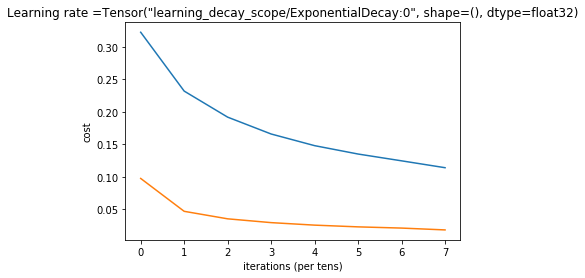

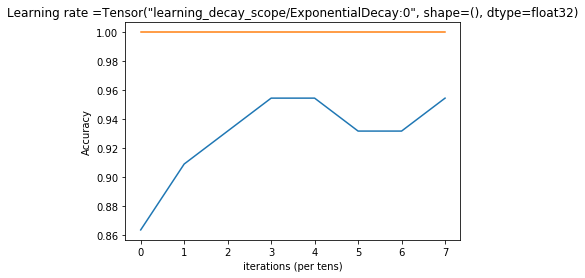

costs_train
[0.32217735797166824, 0.2317382370432218, 0.19168000171581903, 0.1657842273513476, 0.1478584414968888, 0.1349795631443461, 0.12453720237438877, 0.11397150826329987]
costs_dev
[0.09747304394841194, 0.04693275666795671, 0.03539604670368135, 0.02955294685671106, 0.025699779129354283, 0.0230374318525719, 0.02116896979350713, 0.018349890820900328]
{'W1': array([[-0.49147838, -0.4686606 , -0.26952457, -1.6686953 , -0.13119945],
       [ 0.5583348 , -0.49413988,  1.0271014 ,  0.9202534 ,  0.62161714],
       [-0.07997561,  0.66483426, -0.78583205, -0.52282614,  0.6922905 ],
       [ 0.20444623, -0.5348949 ,  0.01580268,  0.00470446, -0.1577248 ],
       [ 0.4755268 ,  0.10101648, -0.5040037 , -0.19751392,  0.7094111 ],
       [ 0.611771  ,  0.101772  , -1.2667456 ,  0.15866487,  0.9893895 ]],
      dtype=float32), 'b1': array([[ 1.17899  ],
       [-1.5819681],
       [-1.56964  ],
       [ 1.3806903],
       [-1.2341124],
       [ 0.9332234]], dtype=float32), 'b2': array([[ 1.203

In [247]:
# NOTE1: Whenever you need to use the framework, you need to update the list of record_defaults that defines
# default values for empty cells in the csv file. Go to decode_csv file to update it.
# NOTE2: Only numerical data is supported right now in the excel file.

# Hyper parameters and optimization parameters
NO_DROPOUT_IN_INPUT_LAYER = 0.
NO_DROPOUT_IN_OUTPUT_LAYER = 0.
###
initial_learning_rate = 0.02
decay_steps = 10
decay_rate = 1.       # if decay_rate=1.  then it means learning decay is not applied
###
num_train_epochs = 80
minibatch_size = 8
epoch_period_to_save_cost = decay_steps   # After how many epochs do you want to save cost & accuracy?
#########
num_units_in_layers = [5,6,2] 
# You only apply dropout in hidden layers. E.g. if rate=0.1 for a layer, 0.1 of units in that layer is dropped out
dropout_rates_per_layer = [NO_DROPOUT_IN_INPUT_LAYER, 0., NO_DROPOUT_IN_OUTPUT_LAYER]    
#########
lambd = 0.     # regularization parameter lambda
#############################
normalize_batch = False
moving_avg_momentum = 0.99   # irrelevant if normalize_batch = False
#############################
########
normalize_input = False
mu= 0.
sigma_square = 1.
########
print_progress = True

# Data may reside in several files. 2 is created here for illustration purposes
train_path1 = "train1.csv"
train_path2 = "train2.csv"
dev_path1 = "dev1.csv"
test_path1 = "test1.csv"
train_input_paths = [train_path1, train_path2]
dev_input_paths = [dev_path1]
test_input_paths = [test_path1]
num_classes = num_units_in_layers[-1]

if normalize_input:
    mu, sigma_square = get_input_norm_params(train_input_paths, minibatch_size)

parameters = nn_model(num_classes, train_input_paths, dev_input_paths, test_input_paths, normalize_input, 
                      mu, sigma_square, initial_learning_rate, decay_steps, decay_rate, num_train_epochs, 
                      normalize_batch, moving_avg_momentum, epoch_period_to_save_cost, minibatch_size, 
                      num_units_in_layers, lambd, dropout_rates_per_layer, print_progress)

print(parameters)

In [236]:
#TODO
# Implement accuracy calculation (on train and test sets)  -- DONE!
# Implement using CSV file(s) even for test data to calculate test accuracy  - DONE!
# Add batch normalization   -- DONE!
# Dropout   -- DONE!
# Add normalization to input params in layer=0  -- DONE!
# For softmax classification particularly, let label be 1 single column and generate the corresponding Y vectors dynamically 
# in the program -- DONE!
# Learning decay -- DONE!
# Accuracy calculation updated with tf.metrics.accuracy() -- DONE!
# Can we use tf.layers.dense(...) for forward propagation?
# Check tensorboard and if you have given appropriate names to your tensors
# Can we use ELU instead of RELU? ELU function has a parameter called alpha that needs to be tuned. The common 
# practice for ELU is to set alpha to 1. (Probably changing it doesnt give that much gain)
# Implement a new program that restores the latest model, takes an input and makes a prediction


abc = []
abc.append(1)
abc.append(5)
print(abc)
print(sum(abc))

[1, 5]
6


In [114]:
der = np.array([3,3,3])
print(len(der))

3
